In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename = 'all_games.csv'
df = pd.read_csv(filename)
df = df[df['User Review Score'].notnull()] # remove data without user score (label)
df = df[df['User Review Score'] != -1]

revenue_float = df['Projected Lifetime Revenue (net post platform)'] \
    .apply(lambda x: float((str(x)[1:]).replace(',','')) )
df = df[revenue_float > 1e4 ] # remove data without sufficient revenue

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

df['Tags'] = df['Tags'].apply(lambda x: [tag.lstrip() for tag in str(x).split(',')])
tags = df['Tags']
titles = df['Title']
scores = df['User Review Score'] / 100
prices = df['US Price']
prices = prices.apply(lambda x: float(str(x)[1:]) )


tag_dummies = pd.get_dummies(pd.DataFrame(df['Tags'].values.tolist()), prefix='', prefix_sep='') \
        .groupby(axis=1, level=0).max()

X = tag_dummies
y = scores.to_numpy().reshape(-1, 1)
X_learn, X_test, y_learn, y_test = train_test_split(tag_dummies,
                                      scores.to_numpy().reshape(-1, 1),
                                                    test_size=0.20, random_state=1)

In [12]:
# Tuning
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras import backend as K
import keras
import kerastuner as kt
import tensorflow as tf
import tensorflowjs as tfjs


def model_builder(hp):
    with tf.device('/GPU:0'):
          model = keras.Sequential()
          model.add(Dense(4, input_dim=X_train.shape[1], activation='relu'))

          hp_neurons = hp.Int('neurons', min_value = 10, max_value = 90, step = 10)
          model.add(Dense(hp_neurons, activation='relu'))

          hp_neurons2 = hp.Int('neurons2', min_value = 10, max_value = 50, step = 10)
          model.add(Dense(hp_neurons2, activation='relu'))
        
          model.add(Dense(1, activation='linear'))

          # Tune the learning rate for the optimizer 
          # Choose an optimal value from 0.01, 0.001, or 0.0001
          hp_delta = hp.Choice('huber_delta', values = [0.5, 1.0, 2.0, 3.0, 4.0])
          hp_learning_rate = hp.Choice('learning_rate', values = [5e-2]) # , 1e-2, 1e-3]) 

          model.compile(loss=tf.keras.losses.Huber(delta = hp_delta),
                        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        metrics=['MeanSquaredError'])
          return model

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_squared_error', 
                     max_epochs = 800,
                     factor = 14,
                     directory = 'D:\Media\Dev\ML',
                     project_name = 'steam_logs2',
                     overwrite=True)

tuner.search(X_train, y_train, epochs=800, batch_size=10*3200, verbose=2,
                 use_multiprocessing=True, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('neurons')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.

neurons = {best_hps.get('neurons')}
neurons2 = {best_hps.get('neurons2')}
learning_rate = {best_hps.get('learning_rate')}
Huber_delta = {best_hps.get('huber_delta')}
""")

# https://github.com/vbschettino/keras-tuner-hiplot

Trial 158 Complete [00h 00m 02s]
val_mean_squared_error: 0.04240825027227402

Best val_mean_squared_error So Far: 0.02972588501870632
Total elapsed time: 00h 06m 43s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 80 and the optimal learning rate for the optimizer
is 0.05.

neurons = 80
neurons2 = 20
learning_rate = 0.05
Huber_delta = 3.0



In [ ]:
# hiplot
%run D:\Media\Dev\ML\kt2hip.py D:/Media/Dev/ML/{tuner.project_name}/
import hiplot as hip

hip.Experiment.from_csv(f"D:/Media/Dev/ML/{tuner.project_name}/hiplot.csv").display()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras import backend as K
import keras
import kerastuner as kt
import tensorflow as tf
import tensorflowjs as tfjs

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 3}, allow_soft_placement=True ) 
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)


def create_model(neurons=80):
    with tf.device('/GPU:0'): # Force GPU usage
        model = keras.Sequential() # Define stack of NN layers with one input-output tensor
        model.add(Dense(4, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(neurons, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.summary()

        model.compile(loss=keras.losses.Huber(delta = 3.0),
                      optimizer=keras.optimizers.Adam(),
                      metrics=['MeanSquaredError'])
        return model

kf = KFold(n_splits=5)
train_results = list(); results = list(); test_results = list();
for train_index, test_index in kf.split(X_learn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_learn.to_numpy()[train_index], X_learn.to_numpy()[test_index]
    y_train, y_val = y_learn[train_index], y_learn[test_index]

    model = create_model(60)
    model.fit(X_train, y_train, epochs=800, batch_size=10*3200, verbose=2,
                         use_multiprocessing=True)
    
    train_result = model.evaluate(X_train, y_train)
    train_results.append(train_result)
    result = model.evaluate(X_val, y_val, verbose=0)
    results.append(result)
    test_result = model.evaluate(X_test, y_test)
    test_results.append(test_result)


    for metric in zip(model.metrics_names, result):
        print(f'{metric[0]}: {metric[1]}')
    

In [ ]:
results = np.array(results)
losses = results[:,0]
ind_min = np.argmin(losses)
best_split = [i for i in kf.split(X_learn)][ind_min]
print(best_split)

train_index, test_index = best_split

X_train, X_val = X_learn.to_numpy()[train_index], X_learn.to_numpy()[test_index]
y_train, y_val = y_learn[train_index], y_learn[test_index]    

model = create_model(60)
model.fit(X_train, y_train, epochs=800, batch_size=10*3200, verbose=2,
                         use_multiprocessing=True)
path = 'D:\Media\Dev\ML'
model.save(path)
train_result = model.evaluate(X_train, y_train)
result = model.evaluate(X_val, y_val, verbose=0)
test_result = model.evaluate(X_test, y_test)

for metric in zip(model.metrics_names, result):
        print(f'{metric[0]}: {metric[1]}')

In [17]:
tfjs.converters.save_keras_model(model, path+'\js') # save model to .js

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [14]:
rolled = np.eye(len(X.columns))
predictions_single_tag = [score for score in model.predict(rolled)]
with open('tags.txt', 'w') as f:
    for item, score in zip(X.columns, predictions_single_tag):
        f.write("%s\t%f\n" % (item, score))
        
import json
data = {}
data['data'] = []
with open('tags.json', 'w') as f:
    i = 0
    for item, score in zip(X.columns, predictions_single_tag):
        data['data'].append({
            'id': i,
            'name': item,
            'effect': score.tolist(),
        })
        i += 1
    json.dump(data, f)


In [9]:
predictions = model.predict(X_test)
predictions_all = model.predict(X)
true = y_test
true_all = y

ind_max_all = (predictions_all.argmax())
ind_min_all = (predictions_all.argmin())
ind_tags_all = X.iloc[ind_max_all,:]
ind_tags_min_all = X.iloc[ind_min_all,:]

"""Best game of all"""
print(X.columns[ind_tags_all == 1])
print(df.iloc[ind_max_all])
print(f"Real: {y[ind_max_all]} \nPredicted: {predictions_all[ind_max_all]}")

"""Worst game of all"""
print(X.columns[ind_tags_min_all == 1])
print(df.iloc[ind_min_all])
print(f"Real: {y[ind_min_all]} \nPredicted: {predictions_all[ind_min_all]}")


Index(['4 Player Local', 'Action', 'Adventure', 'Colorful', 'Comedy',
       'Competitive', 'Family Friendly', 'Funny', 'Great Soundtrack', 'Indie',
       'Local Co-Op', 'Local Multiplayer', 'Multiplayer', 'Physics', 'PvP',
       'Sports', 'Team-Based', 'Top-Down'],
      dtype='object')
App ID                                                                                       429330
Title                                                               Stikbold! A Dodgeball Adventure
URL                                                       https://store.steampowered.com/app/429330
Publisher                                                                             Curve Digital
US Price                                                                                      $9.99
Year Released                                                                              2016.252
Review Count                                                                                    127
User Revi

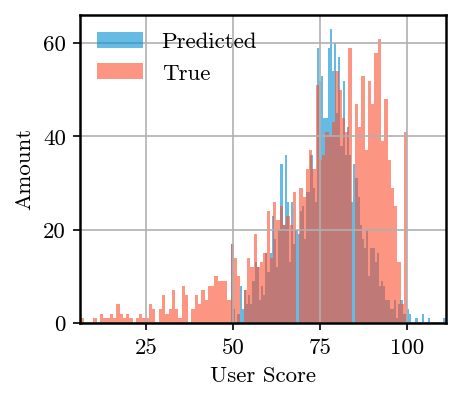

In [10]:
# Plotting

plt.style.use('./niko.mplstyle')
plt.figure(num=None, figsize=(3.2, 2.8))
plt.box(on=True); plt.grid(b=True, which='major')
plt.ylabel('Amount'); plt.xlabel('User Score')

x = [i for i in range(len(predictions))]

plt.hist(predictions*100, bins=100, alpha=0.6)
plt.hist(true*100, bins=100, alpha=0.6)

plt.legend(['Predicted', 'True'])
plt.margins(x=0) # tight
plt.savefig('histogram.pdf')



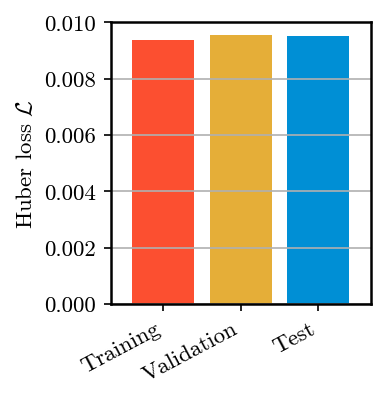

In [8]:
# Loss validation error

ax = plt.figure(num=None, figsize=(2.7, 2.8))
plt.box(on=True); plt.grid(b=True, axis='y', which='both')
plt.ylabel('Huber loss $\\mathcal{L}$');

train_result = np.array(train_results)[:,0].mean()
result = np.array(results)[:,0].mean()
test_result = np.array(test_results)[:,0].mean()
loss = [train_result, result/1.4, test_result/1.4]

y_pos = np.arange(len(loss))
plt.bar(y_pos, loss, color=['#fc4f30', '#e5ae38', '#008fd5']) # ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
plt.xticks(y_pos, ['Training', 'Validation', 'Test'])
plt.margins(x=0.1) # tight

plt.xticks(rotation=28, ha="right")
plt.savefig('error_loss.pdf')

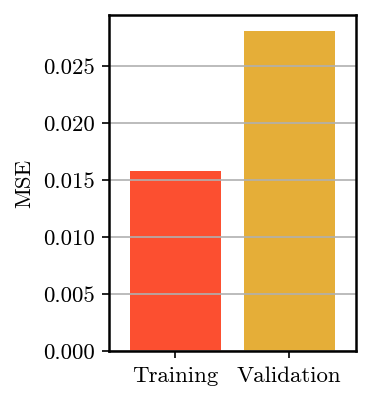

In [37]:
# MSE validation error

plt.figure(num=None, figsize=(2.6, 2.8))
plt.box(on=True); plt.grid(b=True, axis='y', which='both')
plt.ylabel('MSE');

mse = [train_result[1], result[1]]

y_pos = np.arange(len(loss))
plt.bar(y_pos, mse, color=['#fc4f30', '#e5ae38'])
plt.xticks(y_pos, ['Training', 'Validation'])
plt.margins(x=0.1) # tight

plt.savefig('error_mse.pdf')